# Exploring Traditional and Deep Learning Approaches to Online Learning in NBA Game Prediction

### By Peter Wu and Jerry Sun `{plw53, js2746}@cornell.edu`

Online learning approaches have traditionally been used for prediction tasks that involve streams of new data that are increasingly relevant as recency increases. A major possible testbed for such methods is sports, where new data is well-documented. As such, we plan on evaluating several machine learning algorithms on daily sets of new data, with a specialized data collection architecture that translates complicated game data to a suitable data format for the model to train on, day by day. 

## Verifying Colab Runtime Environment Settings

Make sure we are using a high-RAM runtime and are connected to a GPU before running Hedge Backpropagation for our deep neural network.

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Tue Dec  7 21:28:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
    

## Installing Dependencies

(only run this once!)

In [3]:
!pip3 install -U onn
!pip3 install -U imbalanced-learn

  Created wheel for onn: filename=onn-0.2.1-py3-none-any.whl size=4688 sha256=9e7f30d5b2b261058479b531cc1ff2b2d9c4a0f9a6fa1a54f6ebe77480f26270
  Stored in directory: /root/.cache/pip/wheels/09/62/46/9a5dd2903d1bbefffbf53589871a629a20d6e4ddb0a9249702
  Created wheel for mabalgs: filename=mabalgs-0.6.8-py3-none-any.whl size=9712 sha256=566a08a1766169eb966d3e4852c33407f814cd248a9f8daa9f741217d26956e3
  Stored in directory: /root/.cache/pip/wheels/46/dd/ca/c9d5b1955d24d3b8b6244895e29b5dc0884f2ac538090785ea
Successfully built onn mabalgs


## Library Imports

In [4]:
from onn.OnlineNeuralNetwork import ONN
from onn.OnlineNeuralNetwork import ONN_THS
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from imblearn.datasets import make_imbalance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

## Dataset Preprocessing

In [5]:
url = 'https://raw.githubusercontent.com/Silver-Scripters/scraper/main/final.csv'
df = pd.read_csv(url)

# Pre-process features
columns = ['min', 'fg', 'fga', '3p', '3pa', 'ft', 'fta', 'oreb', 'dreb', 'ast', 'stl', 'blk', 'tov', 'pts']
# Name columns for 10 players
for i in range(1, 11):
  for col in columns:
    addon = '' if i == 1 else str(i)
    df[col+addon] = (df[col+addon] - df[col+addon].min()) / df[col+addon].max()

# Normalize team records and pre-process them
df.insert(4, 'team1record', (df['team1_wins'] - df['team1_losses'])/82*0.5 + 0.5)
df.insert(5, 'team2record', (df['team2_wins'] - df['team2_losses'])/82*0.5 + 0.5)
df = df.loc[(df['dates'] != ' 1999') & (df['dates'] != ' 2000')]

# Create Batches for the dates
counter = 0
curr = df['dates'].iloc[0]
for i in range(len(df)):
  if df['dates'].iloc[i] != curr:
    counter += 1
    curr = df['dates'].iloc[i]
  df['dates'].iloc[i] = counter
df = df.reset_index()

# Calculate the labels (winning team)
df['winner'] = (df['team1pts'] > df['team2pts']).astype(int)

# Drop the label constituent columns
df = df.drop(['team1pts', 'team2pts', 'team1_wins', 'team1_losses', 'team2_wins', 'team2_losses'], axis = 1)
print(df['dates'])

data_df = df
data_df = data_df.drop(['index'], axis=1)
batches = []
while len(data_df) > 0:
  current = data_df.loc[(data_df['dates'] == data_df['dates'].iloc[0])]
  batches.append(current)
  data_df = data_df.loc[(data_df['dates'] != data_df['dates'].iloc[0])]

data_df.head()
print(len(batches))

0           0
1           0
2           0
3           1
4           2
         ... 
21652    3899
21653    3900
21654    3901
21655    3902
21656    3903
Name: dates, Length: 21657, dtype: object
3904


## Baseline 1: Online Perceptron

In [45]:
from sklearn.linear_model import Perceptron

accuracies = []
acc = [0, 0]
start = time.time()
# Initialize Model
estimator = Perceptron(tol=1e-3, random_state=0)
for i in range(len(batches)):
    # Determine training batch for this day
    Y = batches[i].iloc[:, -1].to_numpy()
    X = batches[i].iloc[:, :-2].to_numpy()
    np.random.seed(42)
    # Train each sample of data for this batch
    for j in range(len(X)):
      estimator.partial_fit(np.asarray([X[j, :]]), np.asarray([Y[j]]), classes=[0, 1])
    if i < len(batches) - 1:
      # Evaluate Model on Next Day Batch
      X_test = batches[i+1].iloc[:, :-2].to_numpy()
      Y_test = batches[i+1].iloc[:, -1].to_numpy()
      acc[1] += len(X_test)
      predictions = estimator.predict(X_test)
      acc[0] += balanced_accuracy_score(Y_test, predictions)*len(X_test)
      if i % 100 == 0:
        print("Online Accuracy: {}".format(acc[0]/acc[1]))
        accuracies.append(acc[0]/acc[1])
        acc[0] = 0
        acc[1] = 0  
end = time.time()
print("Wall Clock Time: {}".format(end - start))

Online Accuracy: 1.0
Online Accuracy: 0.5076237496794049
Online Accuracy: 0.5655589638718472
Online Accuracy: 0.5424356893106893
Online Accuracy: 0.5488993563304586
Online Accuracy: 0.5122179359548699
Online Accuracy: 0.5936733485578956
Online Accuracy: 0.5480504280363832
Online Accuracy: 0.5554093567251462
Online Accuracy: 0.5667747837658017
Online Accuracy: 0.637876522702104
Online Accuracy: 0.5302973472494021
Online Accuracy: 0.5717713610266805
Online Accuracy: 0.5222116273693943
Online Accuracy: 0.5768816089570806
Online Accuracy: 0.5510132448040944
Online Accuracy: 0.6068754437802056
Online Accuracy: 0.590679012345679
Online Accuracy: 0.6228850171446739
Online Accuracy: 0.5850453254696375
Online Accuracy: 0.5980776594263438
Online Accuracy: 0.6083520599250937
Online Accuracy: 0.6058994389746604
Online Accuracy: 0.615860768175583
Online Accuracy: 0.5690729124510994
Online Accuracy: 0.5357843978937729
Online Accuracy: 0.5843680786267996
Online Accuracy: 0.5642495987158909
Online Acc

Text(0.5, 1.0, '100 Days Running Accuracy Averages for a Perceptron')

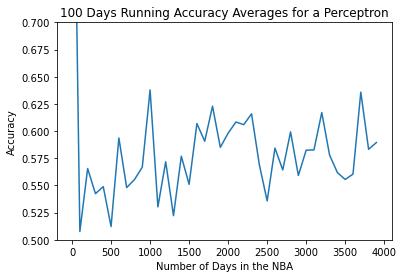

In [46]:
plt.plot([100*i for i in list(range(len(accuracies)))], accuracies)
plt.ylim(0.50, 0.7)
plt.xlabel('Number of Days in the NBA')
plt.ylabel('Accuracy')
plt.title('100 Days Running Accuracy Averages for a Perceptron')


## Baseline 2: Online Logistic Regression

In [47]:
from sklearn.linear_model import SGDClassifier

accuracies = []
acc = [0, 0]
start = time.time()
# Initialize Model
clf = SGDClassifier(max_iter=1000, tol=1e-3, loss='log')

for i in range(len(batches)):
    # Determine training batch for this day
    Y = batches[i].iloc[:, -1].to_numpy()
    X = batches[i].iloc[:, :-2].to_numpy()
    np.random.seed(42)
    # Train each sample of data for this batch
    for j in range(len(X)):
      clf.partial_fit(np.asarray([X[j, :]]), np.asarray([Y[j]]), classes=[0, 1])
      # Evaluate Model on Next Day Batch
    if i < len(batches) - 1:
      X_test = batches[i+1].iloc[:, :-2].to_numpy()
      Y_test = batches[i+1].iloc[:, -1].to_numpy()
      acc[1] += len(X_test)
      predictions = clf.predict(X_test)
      acc[0] += balanced_accuracy_score(Y_test, predictions)*len(X_test)
      if i % 100 == 0:
        print("Online Accuracy: {}".format(acc[0]/acc[1]))
        accuracies.append(acc[0]/acc[1])
        acc[0] = 0
        acc[1] = 0
end = time.time()
print("Wall Clock Time: {}".format(end - start))

Online Accuracy: 1.0
Online Accuracy: 0.48449388732153553
Online Accuracy: 0.5162016749440064
Online Accuracy: 0.5437843406593407
Online Accuracy: 0.5419330396200474
Online Accuracy: 0.5401097837508988
Online Accuracy: 0.562528546054301
Online Accuracy: 0.5587576541228227
Online Accuracy: 0.5421125730994152
Online Accuracy: 0.5977984507176124
Online Accuracy: 0.6005195644149134
Online Accuracy: 0.5601285605566428
Online Accuracy: 0.5775728920409772
Online Accuracy: 0.5205732778548313
Online Accuracy: 0.5779062132835717
Online Accuracy: 0.5386446553930215
Online Accuracy: 0.6174763508096842
Online Accuracy: 0.563508230452675
Online Accuracy: 0.6194881576855827
Online Accuracy: 0.6027022353283821
Online Accuracy: 0.5932765942634365
Online Accuracy: 0.5927314071696094
Online Accuracy: 0.5993534161675756
Online Accuracy: 0.5843756123848716
Online Accuracy: 0.5594692881874185
Online Accuracy: 0.5451822916666667
Online Accuracy: 0.6059270025839795
Online Accuracy: 0.5946682718031032
Online A

Text(0.5, 1.0, '100 Days Running Accuracy Averages for a Logistic Regression')

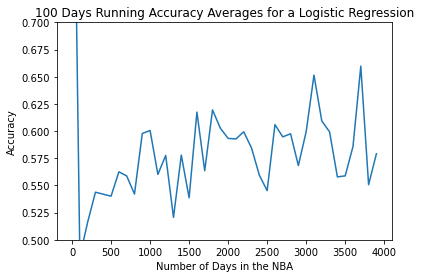

In [48]:
plt.plot([100*i for i in list(range(len(accuracies)))], accuracies)
plt.ylim(0.50, 0.7)
plt.xlabel('Number of Days in the NBA')
plt.ylabel('Accuracy')
plt.title('100 Days Running Accuracy Averages for a Logistic Regression')

## Online Deep Learning

In [19]:
# Initialize Model

onn_network = ONN(features_size = 142, 
                  max_num_hidden_layers = 3, 
                  qtd_neuron_per_hidden_layer = 32, 
                  n_classes = 2)

accuracies = []
acc = [0, 0]
start = time.time()
for i in range(len(batches)):
  # Evaluate Model on Current Day Batch prior to fitting
  X_test = batches[i].iloc[:, :-2].to_numpy()
  Y_test = batches[i].iloc[:, -1].to_numpy()
  acc[1] += len(X_test)
  predictions = onn_network.predict(X_test)
  acc[0] += balanced_accuracy_score(Y_test, predictions)*len(X_test)
  if i % 100 == 0:
    print("Online Accuracy: {}".format(acc[0]/acc[1]))
    accuracies.append(acc[0]/acc[1])
    acc[0] = 0
    acc[1] = 0
    # Determine training batch for this day
  Y = batches[i].iloc[:, -1].to_numpy()
  X = batches[i].iloc[:, :-2].to_numpy()
  # Train each sample of data for this batch
  for j in range(len(X)):
    onn_network.partial_fit(np.asarray([X[j, :]]), np.asarray([Y[j]]), show_loss=False)
end = time.time()
print("Wall Clock Time: {}".format(end - start))

Online Accuracy: 0.25
Online Accuracy: 0.5119479733817301
Online Accuracy: 0.5252525252525253
Online Accuracy: 0.5211640211640212
Online Accuracy: 0.5185185185185185
Online Accuracy: 0.5272887323943662
Online Accuracy: 0.5377855887521968
Online Accuracy: 0.53125
Online Accuracy: 0.5234782608695652
Online Accuracy: 0.5212981744421906
Online Accuracy: 0.5145482388973966
Online Accuracy: 0.5081585081585082
Online Accuracy: 0.5210674157303371
Online Accuracy: 0.5392156862745098
Online Accuracy: 0.5130057803468208
Online Accuracy: 0.5286975717439294
Online Accuracy: 0.5085592011412268
Online Accuracy: 0.5420792079207921
Online Accuracy: 0.5064655172413793
Online Accuracy: 0.545662100456621
Online Accuracy: 0.5058565153733529
Online Accuracy: 0.5446428571428571
Online Accuracy: 0.5301914580265096
Online Accuracy: 0.5529045643153527
Online Accuracy: 0.5014144271570015
Online Accuracy: 0.5447941888619855
Online Accuracy: 0.5124269005847953
Online Accuracy: 0.5529279279279279
Online Accuracy: 0

Text(0.5, 1.0, '100 Days Running Accuracy Averages for ONN')

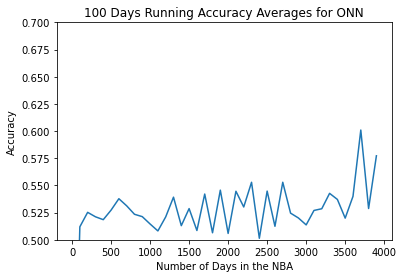

In [20]:
plt.plot([100*i for i in list(range(len(accuracies)))], accuracies)
plt.ylim(0.50, 0.7)
plt.xlabel('Number of Days in the NBA')
plt.ylabel('Accuracy')
plt.title('100 Days Running Accuracy Averages for ONN')

## Experiment 2

In [8]:
# Network Definitions
network_size = 32
linear_input = 142
class NN(torch.nn.Module):
  def __init__(self, linear_input, network_size):
      super(NN, self).__init__()
      self.fc1 = torch.nn.Linear(linear_input, network_size)
      self.relu = torch.nn.LeakyReLU(0.1)
      self.fc2 = torch.nn.Linear(network_size, network_size)
      self.relu = torch.nn.LeakyReLU(0.1)
      self.fc3 = torch.nn.Linear(network_size, network_size)
      self.relu = torch.nn.LeakyReLU(0.1)
      self.fc4 = torch.nn.Linear(network_size, 1)
      self.sigmoid = torch.nn.Sigmoid()
  def forward(self, x):
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      x = self.relu(x)
      x = self.fc4(x)
      x = self.sigmoid(x)
      return x


In [55]:
# Training definition
def train(model, loss, optimizer):
  training = []
  accuracies = []
  test_batch = batches[3404:]
  test = test_batch[0]
  # Split into train and test batch
  for i in range(1, len(test_batch)):
    test = pd.concat([test, test_batch[i]], ignore_index=True)
  X_test = torch.from_numpy(test.iloc[:, :-2].to_numpy()).float()
  Y_test = test.iloc[:, -1].to_numpy()
  train_batch = batches[:3404]
  train = train_batch[0]
  for i in range(1, len(train_batch)):
    train = pd.concat([train, train_batch[i]], ignore_index=True)
  X = torch.from_numpy(train.iloc[:, :-2].to_numpy()).float()
  Y = torch.from_numpy(train.iloc[:, -1].to_numpy()).float()


  start = time.time()
  # Train for 800 epochs
  for i in range(800):
    train_loss = 0
    model.train()
    preds = model(X)
    loss_ = loss(preds.squeeze(), Y)
    train_loss += loss_.item()
    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()
    training.append(train_loss)
    # Every 10 epochs evaluate
    if i % 10 == 0:
      with torch.no_grad():
        model.eval()
        preds = torch.round(model(X_test)).numpy()
        correct = 0
        accuracy = balanced_accuracy_score(preds, Y_test)
      print("Training Loss: {}".format(loss_.item()))
      print("Online Accuracy: {}".format(accuracy))
      accuracies.append(accuracy)

  end = time.time()
  print("Wall Clock Time: {}".format(end - start))
  return accuracies, training

In [58]:
model = NN(linear_input, network_size)
loss = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, weight_decay=5e-6)
accuracies, training = train(model, loss, optimizer)

Training Loss: 0.7047199010848999
Online Accuracy: 0.4071207430340557
Training Loss: 0.6865364909172058
Online Accuracy: 0.5928792569659442
Training Loss: 0.6786632537841797
Online Accuracy: 0.5928792569659442
Training Loss: 0.6752898097038269
Online Accuracy: 0.5928792569659442
Training Loss: 0.6738721132278442
Online Accuracy: 0.5928792569659442
Training Loss: 0.6732821464538574
Online Accuracy: 0.5928792569659442
Training Loss: 0.6730364561080933
Online Accuracy: 0.5928792569659442
Training Loss: 0.6729323267936707
Online Accuracy: 0.5928792569659442
Training Loss: 0.6728860139846802
Online Accuracy: 0.5928792569659442
Training Loss: 0.6728630065917969
Online Accuracy: 0.5928792569659442
Training Loss: 0.6728496551513672
Online Accuracy: 0.5928792569659442
Training Loss: 0.672840416431427
Online Accuracy: 0.5928792569659442
Training Loss: 0.6728327870368958
Online Accuracy: 0.5928792569659442
Training Loss: 0.6728259325027466
Online Accuracy: 0.5928792569659442
Training Loss: 0.6728

Text(0.5, 1.0, 'Accuracy across Epochs for DNN with SGD')

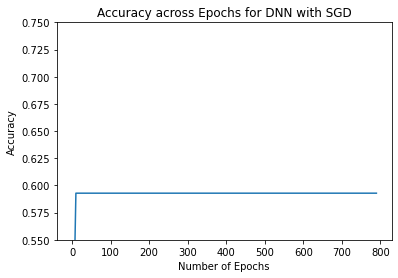

In [59]:
plt.plot([10*i for i in list(range(len(accuracies)))], accuracies)
plt.ylim(0.55, 0.75)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy across Epochs for DNN with SGD')

In [67]:
model = NN(linear_input, network_size)
loss = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, nesterov=False, weight_decay=5e-6)
accuracies, training = train(model, loss, optimizer)

Training Loss: 0.7067005038261414
Online Accuracy: 0.4071207430340557
Training Loss: 0.6730005741119385
Online Accuracy: 0.5928792569659442
Training Loss: 0.6753986477851868
Online Accuracy: 0.5928792569659442
Training Loss: 0.6733291149139404
Online Accuracy: 0.5928792569659442
Training Loss: 0.6727922558784485
Online Accuracy: 0.5928792569659442
Training Loss: 0.6727498769760132
Online Accuracy: 0.5928792569659442
Training Loss: 0.672573447227478
Online Accuracy: 0.5928792569659442
Training Loss: 0.6725242137908936
Online Accuracy: 0.5928792569659442
Training Loss: 0.6724235415458679
Online Accuracy: 0.5928792569659442
Training Loss: 0.6723182797431946
Online Accuracy: 0.5928792569659442
Training Loss: 0.6721802353858948
Online Accuracy: 0.5928792569659442
Training Loss: 0.6719990372657776
Online Accuracy: 0.5928792569659442
Training Loss: 0.6717415452003479
Online Accuracy: 0.5928792569659442
Training Loss: 0.671410083770752
Online Accuracy: 0.5928792569659442
Training Loss: 0.67097

Text(0.5, 1.0, 'Accuracy across Epochs for DNN with SDG and Momentum')

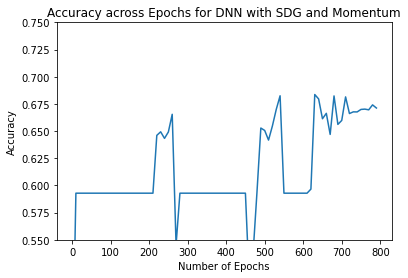

In [68]:
plt.plot([10*i for i in list(range(len(accuracies)))], accuracies)
plt.ylim(0.55, 0.75)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy across Epochs for DNN with SDG and Momentum')

In [69]:
model = NN(linear_input, network_size)
loss = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, nesterov=True, weight_decay=5e-6)
accuracies, training = train(model, loss, optimizer)

Training Loss: 0.7014290690422058
Online Accuracy: 0.4071207430340557
Training Loss: 0.6730817556381226
Online Accuracy: 0.5928792569659442
Training Loss: 0.6738413572311401
Online Accuracy: 0.5928792569659442
Training Loss: 0.6729662418365479
Online Accuracy: 0.5928792569659442
Training Loss: 0.6727504134178162
Online Accuracy: 0.5928792569659442
Training Loss: 0.6727005243301392
Online Accuracy: 0.5928792569659442
Training Loss: 0.6726227402687073
Online Accuracy: 0.5928792569659442
Training Loss: 0.6725549697875977
Online Accuracy: 0.5928792569659442
Training Loss: 0.6724687218666077
Online Accuracy: 0.5928792569659442
Training Loss: 0.6723646521568298
Online Accuracy: 0.5928792569659442
Training Loss: 0.6722395420074463
Online Accuracy: 0.5928792569659442
Training Loss: 0.6720874905586243
Online Accuracy: 0.5928792569659442
Training Loss: 0.6718973517417908
Online Accuracy: 0.5928792569659442
Training Loss: 0.6716530323028564
Online Accuracy: 0.5928792569659442
Training Loss: 0.671

Text(0.5, 1.0, 'Accuracy across Epochs for DNN with SDG and Nesterov Momentum')

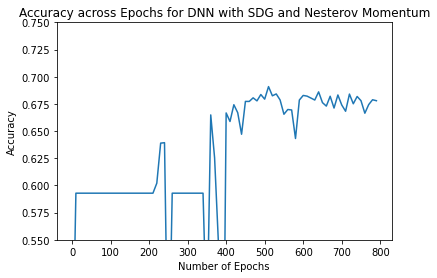

In [70]:
plt.plot([10*i for i in list(range(len(accuracies)))], accuracies)
plt.ylim(0.55, 0.75)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy across Epochs for DNN with SDG and Nesterov Momentum')

In [71]:
model = NN(linear_input, network_size)
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05, weight_decay=1e-5)
accuracies, training = train(model, loss, optimizer)

Training Loss: 0.7056742906570435
Online Accuracy: 0.5928792569659442
Training Loss: 0.6750909090042114
Online Accuracy: 0.5928792569659442
Training Loss: 0.6644356846809387
Online Accuracy: 0.47013327825062323
Training Loss: 0.6820714473724365
Online Accuracy: 0.5771864009378664
Training Loss: 0.6735105514526367
Online Accuracy: 0.5928792569659442
Training Loss: 0.6714621186256409
Online Accuracy: 0.5928792569659442
Training Loss: 0.6712740063667297
Online Accuracy: 0.5928792569659442
Training Loss: 0.6670325398445129
Online Accuracy: 0.5928792569659442
Training Loss: 0.6474797129631042
Online Accuracy: 0.5906095284473662
Training Loss: 0.6536524891853333
Online Accuracy: 0.6021671826625388
Training Loss: 0.6523550748825073
Online Accuracy: 0.6151107276387691
Training Loss: 0.6383461356163025
Online Accuracy: 0.6254357732986966
Training Loss: 0.6361890435218811
Online Accuracy: 0.6225949459907152
Training Loss: 0.6972208023071289
Online Accuracy: 0.5928792569659442
Training Loss: 0.63

Text(0.5, 1.0, 'Accuracy across Epochs for DNN with Adam')

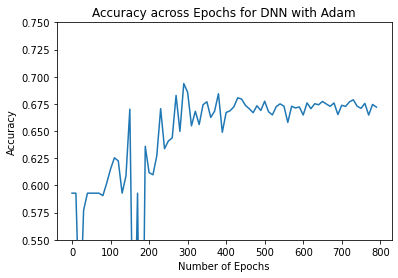

In [72]:
plt.plot([10*i for i in list(range(len(accuracies)))], accuracies)
plt.ylim(0.55, 0.75)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy across Epochs for DNN with Adam')